## 1. Import Libraries

In [50]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Model persistence
import joblib
import json

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load Data

In [51]:
# Load data dari file Excel
df = pd.read_excel('NPL Prep.xlsx')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: (1500, 15)

Columns: ['Pekerjaan', 'tanggal_lahir', 'Status', 'produk', 'sub_produk', 'tanggal_input', 'plafond', 'jk_waktubulan', 'Hasil Prescreening SLIK', 'Hasil Prescreening SIKPKUR', 'Hasil Prescreening Dukcapil', 'Hasil Prescreening DHNBI', 'Hasil Prescreening', 'Status.1', 'Kolektabilitas']

First 5 rows:


,Pekerjaan,tanggal_lahir,Status,produk,sub_produk,tanggal_input,plafond,jk_waktubulan,Hasil Prescreening SLIK,Hasil Prescreening SIKPKUR,Hasil Prescreening Dukcapil,Hasil Prescreening DHNBI,Hasil Prescreening,Status.1,Kolektabilitas
0,Pegawai pemerintahan/lembaga negara,1978-06-06,Kawin,Konsumer,Kredit Multi Guna,2022-10-03,141200000.0,60,Low,TIDAK DILAKUKAN,Sesuai,Tidak,Lolos,Accept,Lancar
1,"Pengajar (Guru,Dosen)",1975-04-30,Belum Kawin,Konsumer,Kredit Multi Guna,2024-09-27,418000000.0,126,High,TIDAK DILAKUKAN,Sesuai,Tidak,Lolos,Waiting Approval,Tidak Lancar
2,"Pengajar (Guru,Dosen)",1986-03-15,Kawin,Konsumer,Kredit Multi Guna,2024-06-03,265500000.0,192,Low,TIDAK DILAKUKAN,Sesuai,Tidak,Lolos,Accept,Lancar
3,Pegawai pemerintahan/lembaga negara,1971-09-12,Kawin,Konsumer,Kredit Multi Guna,2020-07-07,305000000.0,109,Low,TIDAK DILAKUKAN,Sesuai,Tidak,Lolos,Accept,Lancar
4,Pegawai pemerintahan/lembaga negara,1976-09-23,Kawin,Konsumer,Kredit Multi Guna,2024-04-24,91000000.0,60,High,TIDAK DILAKUKAN,Sesuai,Tidak,Lolos,Waiting Approval,Tidak Lancar


## 3. Feature Engineering: Create USIA (Age)

In [52]:
# Convert date columns to datetime
df['tanggal_lahir'] = pd.to_datetime(df['tanggal_lahir'])
df['tanggal_input'] = pd.to_datetime(df['tanggal_input'])

# Calculate USIA (age in years)
df['USIA'] = ((df['tanggal_input'] - df['tanggal_lahir']).dt.days / 365.25).round(0).astype(int)

print("✓ USIA attribute created")
print(f"\nUSIA statistics:")
print(df['USIA'].describe())
print(f"\nSample data:")
df[['tanggal_lahir', 'tanggal_input', 'USIA']].head(10)

✓ USIA attribute created

USIA statistics:
count    1500.000000
mean       41.837333
std         9.953337
min        19.000000
25%        34.000000
50%        42.000000
75%        49.000000
max        70.000000
Name: USIA, dtype: float64

Sample data:


,tanggal_lahir,tanggal_input,USIA
0,1978-06-06,2022-10-03,44
1,1975-04-30,2024-09-27,49
2,1986-03-15,2024-06-03,38
3,1971-09-12,2020-07-07,49
4,1976-09-23,2024-04-24,48
5,1981-08-15,2015-02-24,34
6,1989-06-28,2023-09-29,34
7,1989-01-14,2025-03-10,36
8,1979-08-08,2024-01-23,44
9,1960-05-15,2023-09-14,63


## 4. Remove Unnecessary Date Columns

In [53]:
# Drop tanggal_lahir and tanggal_input columns
df = df.drop(['tanggal_lahir', 'tanggal_input'], axis=1)

print("✓ Date columns removed")
print(f"\nNew shape: {df.shape}")
print(f"\nRemaining columns:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")

✓ Date columns removed

New shape: (1500, 14)

Remaining columns:
1. Pekerjaan
2. Status
3. produk
4. sub_produk
5. plafond
6. jk_waktubulan
7. Hasil Prescreening SLIK
8. Hasil Prescreening SIKPKUR
9. Hasil Prescreening Dukcapil
10. Hasil Prescreening DHNBI
11. Hasil Prescreening
12. Status.1
13. Kolektabilitas
14. USIA


## 5. Reorder and Rename Columns

In [54]:
# Rename columns to match requirements
column_mapping = {
    'Pekerjaan': 'Pekerjaan',
    'USIA': 'Usia',
    'Status': 'Status Pernikahan',
    'produk': 'Produk',
    'sub_produk': 'Sub Produk',
    'plafond': 'Plafond',
    'jk_waktubulan': 'Jangka Waktu',
    'Hasil Prescreening SLIK': 'Hasil Prescreening SLIK',
    'Hasil Prescreening SIKPKUR': 'Hasil Prescreening SIPKUR',
    'Hasil Prescreening Dukcapil': 'Hasil Prescreening Dukcapil',
    'Hasil Prescreening': 'Hasil Prescreening',
    'Status.1': 'Status',
    'Kolektabilitas': 'Kolektabilitas'
}

df = df.rename(columns=column_mapping)

# Reorder columns as specified
desired_columns = [
    'Pekerjaan',
    'Usia',
    'Status Pernikahan',
    'Produk',
    'Sub Produk',
    'Plafond',
    'Jangka Waktu',
    'Hasil Prescreening SLIK',
    'Hasil Prescreening SIPKUR',
    'Hasil Prescreening Dukcapil',
    'Hasil Prescreening',
    'Status',
    'Kolektabilitas'
]

df = df[desired_columns]

print("✓ Columns renamed and reordered")
print(f"\nFinal columns:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")

print(f"\nFirst 5 rows:")
df.head()

✓ Columns renamed and reordered

Final columns:
1. Pekerjaan
2. Usia
3. Status Pernikahan
4. Produk
5. Sub Produk
6. Plafond
7. Jangka Waktu
8. Hasil Prescreening SLIK
9. Hasil Prescreening SIPKUR
10. Hasil Prescreening Dukcapil
11. Hasil Prescreening
12. Status
13. Kolektabilitas

First 5 rows:


,Pekerjaan,Usia,Status Pernikahan,Produk,Sub Produk,Plafond,Jangka Waktu,Hasil Prescreening SLIK,Hasil Prescreening SIPKUR,Hasil Prescreening Dukcapil,Hasil Prescreening,Status,Kolektabilitas
0,Pegawai pemerintahan/lembaga negara,44,Kawin,Konsumer,Kredit Multi Guna,141200000.0,60,Low,TIDAK DILAKUKAN,Sesuai,Lolos,Accept,Lancar
1,"Pengajar (Guru,Dosen)",49,Belum Kawin,Konsumer,Kredit Multi Guna,418000000.0,126,High,TIDAK DILAKUKAN,Sesuai,Lolos,Waiting Approval,Tidak Lancar
2,"Pengajar (Guru,Dosen)",38,Kawin,Konsumer,Kredit Multi Guna,265500000.0,192,Low,TIDAK DILAKUKAN,Sesuai,Lolos,Accept,Lancar
3,Pegawai pemerintahan/lembaga negara,49,Kawin,Konsumer,Kredit Multi Guna,305000000.0,109,Low,TIDAK DILAKUKAN,Sesuai,Lolos,Accept,Lancar
4,Pegawai pemerintahan/lembaga negara,48,Kawin,Konsumer,Kredit Multi Guna,91000000.0,60,High,TIDAK DILAKUKAN,Sesuai,Lolos,Waiting Approval,Tidak Lancar


## 6. Data Exploration

In [55]:
# Basic information
print("Dataset Information:")
print("=" * 50)
print(f"Total records: {len(df)}")
print(f"Total features: {len(df.columns) - 1}")
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nDuplicate rows: {df.duplicated().sum()}")

Dataset Information:
Total records: 1500
Total features: 12

Data types:
Pekerjaan                       object
Usia                             int64
Status Pernikahan               object
Produk                          object
Sub Produk                      object
Plafond                        float64
Jangka Waktu                     int64
Hasil Prescreening SLIK         object
Hasil Prescreening SIPKUR       object
Hasil Prescreening Dukcapil     object
Hasil Prescreening              object
Status                          object
Kolektabilitas                  object
dtype: object

Missing values:
Pekerjaan                      0
Usia                           0
Status Pernikahan              0
Produk                         0
Sub Produk                     0
Plafond                        0
Jangka Waktu                   0
Hasil Prescreening SLIK        0
Hasil Prescreening SIPKUR      0
Hasil Prescreening Dukcapil    0
Hasil Prescreening             0
Status                    

Target Variable: Kolektabilitas
Kolektabilitas
Lancar          1100
Tidak Lancar     400
Name: count, dtype: int64

Percentage:
Kolektabilitas
Lancar          73.333333
Tidak Lancar    26.666667
Name: proportion, dtype: float64


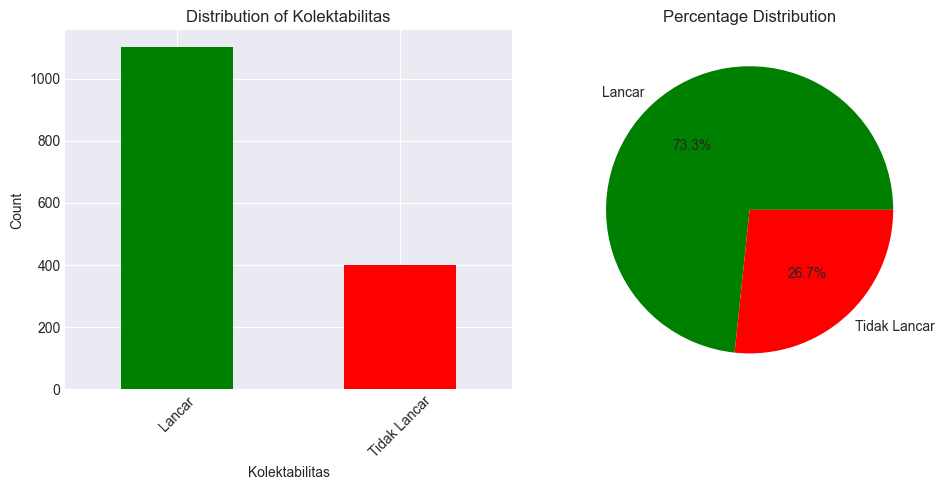

In [56]:
# Target variable distribution
print("Target Variable: Kolektabilitas")
print("=" * 50)
print(df['Kolektabilitas'].value_counts())
print(f"\nPercentage:")
print(df['Kolektabilitas'].value_counts(normalize=True) * 100)

# Visualize target distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['Kolektabilitas'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Kolektabilitas')
plt.xlabel('Kolektabilitas')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df['Kolektabilitas'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red'])
plt.title('Percentage Distribution')
plt.ylabel('')

plt.tight_layout()
plt.show()

In [57]:
# Numerical features statistics
print("Numerical Features Statistics:")
print("=" * 50)
df[['Usia', 'Plafond', 'Jangka Waktu']].describe()

Numerical Features Statistics:


,Usia,Plafond,Jangka Waktu
count,1500.000000,1.500000e+03,1500.000000
mean,41.837333,2.196511e+08,92.095333
std,9.953337,2.225929e+08,58.359285
min,19.000000,1.914000e+06,5.000000
25%,34.000000,7.500000e+07,48.750000
50%,42.000000,1.655000e+08,67.000000
75%,49.000000,2.828000e+08,121.000000
max,70.000000,3.000000e+09,240.000000


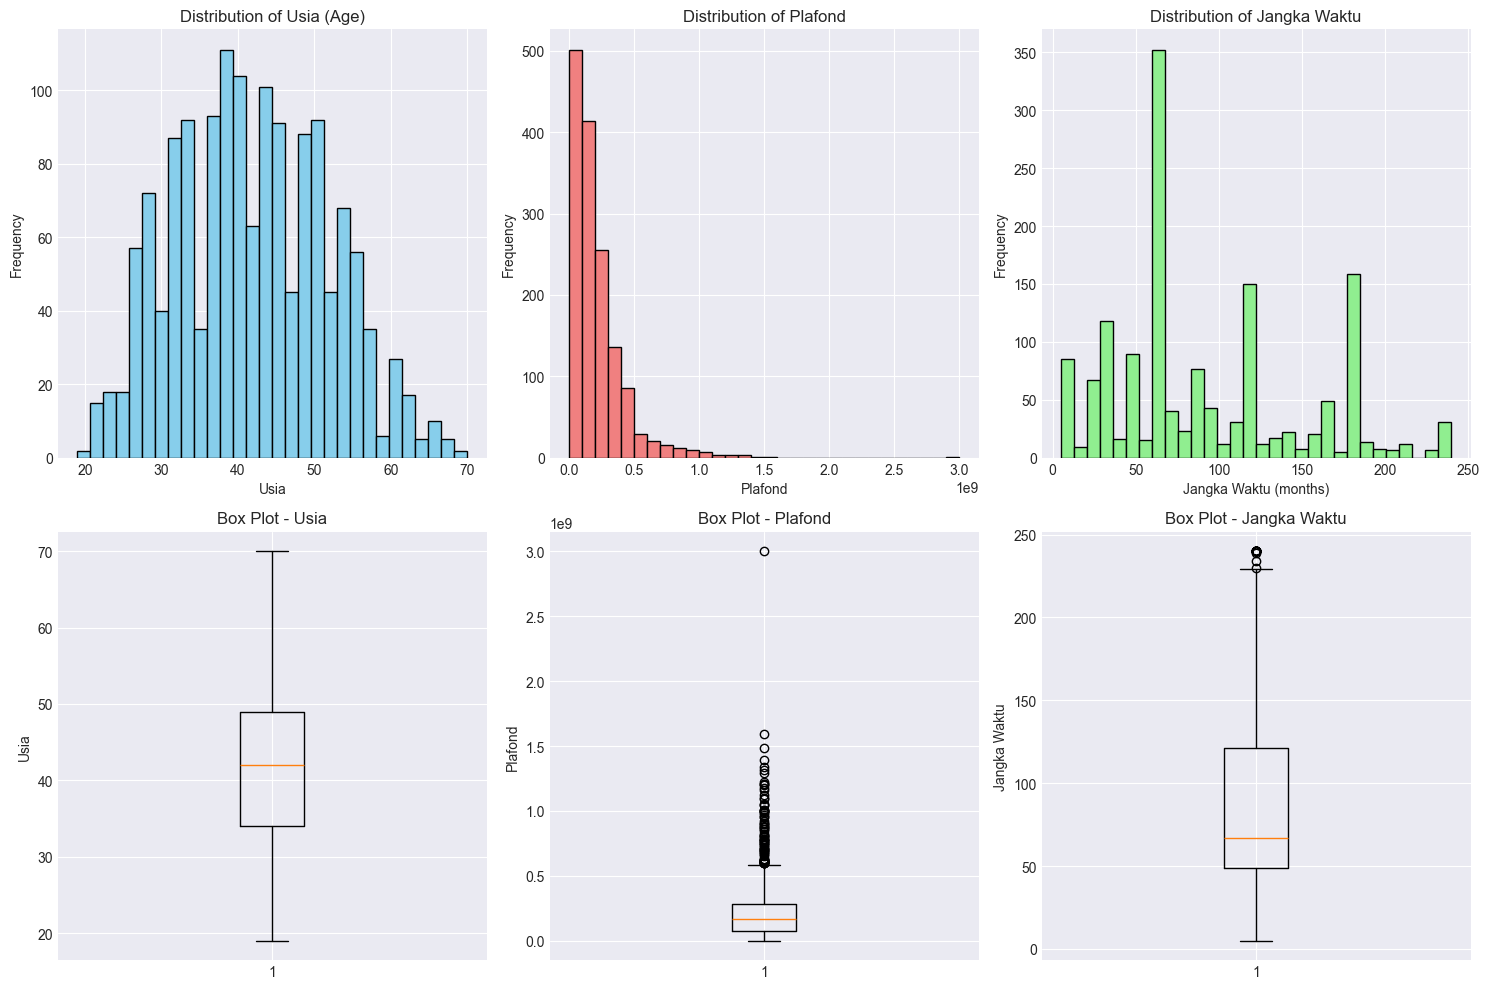

In [58]:
# Visualize numerical features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Usia
axes[0, 0].hist(df['Usia'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Usia (Age)')
axes[0, 0].set_xlabel('Usia')
axes[0, 0].set_ylabel('Frequency')

# Plafond
axes[0, 1].hist(df['Plafond'], bins=30, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Plafond')
axes[0, 1].set_xlabel('Plafond')
axes[0, 1].set_ylabel('Frequency')

# Jangka Waktu
axes[0, 2].hist(df['Jangka Waktu'], bins=30, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Distribution of Jangka Waktu')
axes[0, 2].set_xlabel('Jangka Waktu (months)')
axes[0, 2].set_ylabel('Frequency')

# Box plots
axes[1, 0].boxplot(df['Usia'])
axes[1, 0].set_title('Box Plot - Usia')
axes[1, 0].set_ylabel('Usia')

axes[1, 1].boxplot(df['Plafond'])
axes[1, 1].set_title('Box Plot - Plafond')
axes[1, 1].set_ylabel('Plafond')

axes[1, 2].boxplot(df['Jangka Waktu'])
axes[1, 2].set_title('Box Plot - Jangka Waktu')
axes[1, 2].set_ylabel('Jangka Waktu')

plt.tight_layout()
plt.show()

In [59]:
# Categorical features
categorical_features = ['Pekerjaan', 'Status Pernikahan', 'Produk', 'Sub Produk', 
                        'Hasil Prescreening SLIK', 'Hasil Prescreening SIPKUR', 
                        'Hasil Prescreening Dukcapil', 'Hasil Prescreening', 'Status']

print("Categorical Features Summary:")
print("=" * 50)
for feature in categorical_features:
    print(f"\n{feature}:")
    print(df[feature].value_counts())
    print("-" * 50)

Categorical Features Summary:

Pekerjaan:
Pekerjaan
Pegawai pemerintahan/lembaga negara              433
Pengajar (Guru,Dosen)                            297
Lain-Lain                                        213
Wiraswasta                                       116
Administrasi umum                                107
Tenaga Medis (Perawat, Bidan, dan sebagainya)     67
Pensiunan                                         48
Eksekutif                                         45
Transportasi darat (masinis, sopir,kondektur)     41
Pengamanan                                        32
Pelajar/Mahasiswa                                 24
Marketing                                         14
Ibu rumah tangga                                   9
Pejabat negara/penyelenggara negara                7
Konsultan/Analis                                   7
Teknologi informasi                                7
Accounting/Finance Officer                         7
Dokter                                         

## 7. Standardize Kolektabilitas Values

In [60]:
# Check unique values in Kolektabilitas
print("Unique values in Kolektabilitas:")
print(df['Kolektabilitas'].unique())

# Standardize to 'Lancar' and 'Tidak Lancar'
# Map variations to standard values
kolektabilitas_mapping = {
    'Lancar': 'Lancar',
    'lancar': 'Lancar',
    'LANCAR': 'Lancar',
    'Tidak Lancar': 'Tidak Lancar',
    'tidak lancar': 'Tidak Lancar',
    'TIDAK LANCAR': 'Tidak Lancar',
    'Macet': 'Tidak Lancar'
}

df['Kolektabilitas'] = df['Kolektabilitas'].map(lambda x: kolektabilitas_mapping.get(x, x))

print("\n✓ Kolektabilitas standardized")
print("\nFinal distribution:")
print(df['Kolektabilitas'].value_counts())

Unique values in Kolektabilitas:
['Lancar' 'Tidak Lancar']

✓ Kolektabilitas standardized

Final distribution:
Kolektabilitas
Lancar          1100
Tidak Lancar     400
Name: count, dtype: int64


## 8. Correlation Analysis

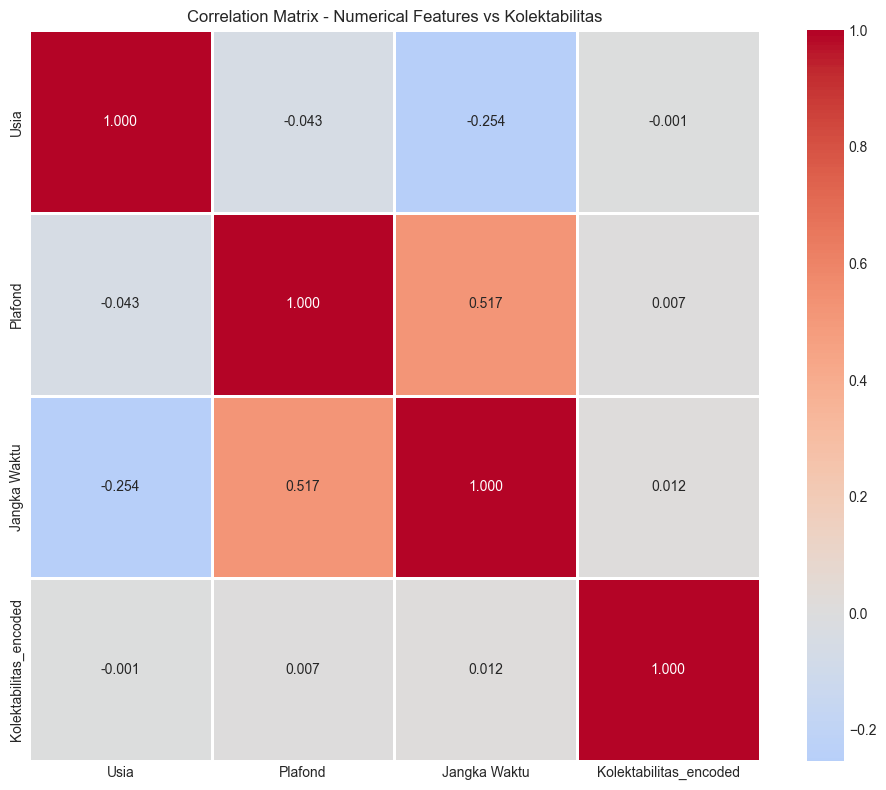


Correlation with Kolektabilitas:
Kolektabilitas_encoded    1.000000
Jangka Waktu              0.012090
Plafond                   0.006736
Usia                     -0.001354
Name: Kolektabilitas_encoded, dtype: float64


In [61]:
# Create a copy for correlation analysis
df_numeric = df.copy()

# Encode target variable
df_numeric['Kolektabilitas_encoded'] = (df_numeric['Kolektabilitas'] == 'Tidak Lancar').astype(int)

# Select numerical columns
numeric_cols = ['Usia', 'Plafond', 'Jangka Waktu', 'Kolektabilitas_encoded']
correlation_matrix = df_numeric[numeric_cols].corr()

# Visualize correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, linewidths=1)
plt.title('Correlation Matrix - Numerical Features vs Kolektabilitas')
plt.tight_layout()
plt.show()

print("\nCorrelation with Kolektabilitas:")
print(correlation_matrix['Kolektabilitas_encoded'].sort_values(ascending=False))

## 9. Feature Encoding

In [62]:
# Prepare data for modeling
df_model = df.copy()

# Separate features and target
X = df_model.drop('Kolektabilitas', axis=1)
y = df_model['Kolektabilitas']

# Encode categorical features
label_encoders = {}
categorical_columns = X.select_dtypes(include=['object']).columns

print("Encoding categorical features...")
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"✓ {col}")

# Encode target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"\n✓ All features encoded")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y_encoded.shape}")
print(f"\nTarget encoding: {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")

Encoding categorical features...
✓ Pekerjaan
✓ Status Pernikahan
✓ Produk
✓ Sub Produk
✓ Hasil Prescreening SLIK
✓ Hasil Prescreening SIPKUR
✓ Hasil Prescreening Dukcapil
✓ Hasil Prescreening
✓ Status

✓ All features encoded

Feature matrix shape: (1500, 12)
Target vector shape: (1500,)

Target encoding: {'Lancar': np.int64(0), 'Tidak Lancar': np.int64(1)}


## 10. Train-Test Split

In [63]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Data Split Summary:")
print("=" * 50)
print(f"Training set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTraining set distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest set distribution:")
print(pd.Series(y_test).value_counts())

Data Split Summary:
Training set size: 1200 (80.0%)
Test set size: 300 (20.0%)

Training set distribution:
0    880
1    320
Name: count, dtype: int64

Test set distribution:
0    220
1     80
Name: count, dtype: int64


## 11. Feature Scaling

In [64]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")
print(f"\nOriginal feature ranges (first 3 features):")
print(X_train.iloc[:, :3].describe().loc[['min', 'max']])
print(f"\nScaled feature ranges (first 3 features):")
print(pd.DataFrame(X_train_scaled[:, :3]).describe().loc[['min', 'max']])

✓ Features scaled using StandardScaler

Original feature ranges (first 3 features):
     Pekerjaan  Usia  Status Pernikahan
min        0.0  19.0                0.0
max       25.0  70.0                2.0

Scaled feature ranges (first 3 features):
            0         1         2
min -2.220915 -2.300921 -2.426726
max  1.823485  2.829936  0.462233


## 12. Model Training - Random Forest

In [65]:
# Train Random Forest model
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
print("✓ Random Forest model trained")

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"ROC-AUC Score: {roc_auc_rf:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=target_encoder.classes_))

Training Random Forest Classifier...
✓ Random Forest model trained

Random Forest Performance:
Accuracy: 1.0000
ROC-AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Lancar       1.00      1.00      1.00       220
Tidak Lancar       1.00      1.00      1.00        80

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



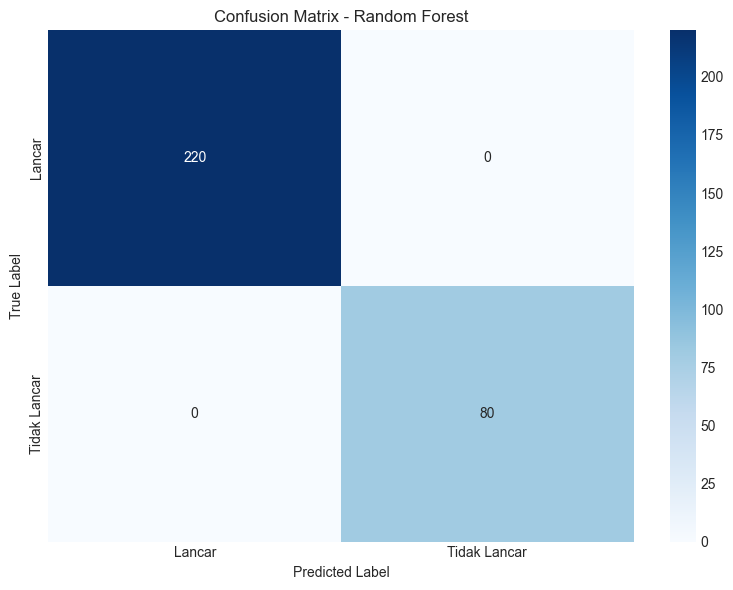

In [66]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_encoder.classes_, 
            yticklabels=target_encoder.classes_)
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Feature Importance:
                        feature  importance
7       Hasil Prescreening SLIK    0.623479
11                       Status    0.235393
10           Hasil Prescreening    0.102220
9   Hasil Prescreening Dukcapil    0.018646
1                          Usia    0.004479
6                  Jangka Waktu    0.003685
5                       Plafond    0.003343
8     Hasil Prescreening SIPKUR    0.002906
0                     Pekerjaan    0.002570
4                    Sub Produk    0.001963
3                        Produk    0.001063
2             Status Pernikahan    0.000254


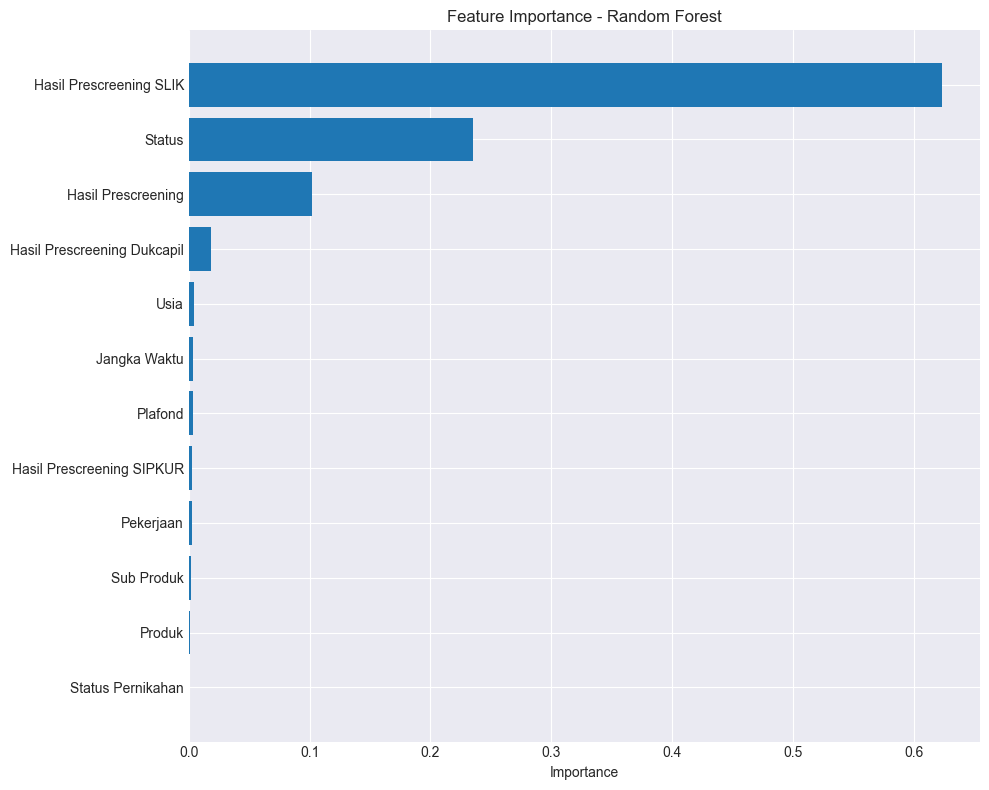

In [67]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 13. Model Training - Gradient Boosting

In [68]:
# Train Gradient Boosting model
print("Training Gradient Boosting Classifier...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)
print("✓ Gradient Boosting model trained")

# Make predictions
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

print(f"\nGradient Boosting Performance:")
print(f"Accuracy: {accuracy_gb:.4f}")
print(f"ROC-AUC Score: {roc_auc_gb:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=target_encoder.classes_))

Training Gradient Boosting Classifier...
✓ Gradient Boosting model trained

Gradient Boosting Performance:
Accuracy: 1.0000
ROC-AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Lancar       1.00      1.00      1.00       220
Tidak Lancar       1.00      1.00      1.00        80

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



## 14. Model Training - AdaBoost

In [69]:
# Train AdaBoost model
print("Training AdaBoost Classifier...")
ada_model = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

ada_model.fit(X_train_scaled, y_train)
print("✓ AdaBoost model trained")

# Make predictions
y_pred_ada = ada_model.predict(X_test_scaled)
y_pred_proba_ada = ada_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
accuracy_ada = accuracy_score(y_test, y_pred_ada)
roc_auc_ada = roc_auc_score(y_test, y_pred_proba_ada)

print(f"\nAdaBoost Performance:")
print(f"Accuracy: {accuracy_ada:.4f}")
print(f"ROC-AUC Score: {roc_auc_ada:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_ada, target_names=target_encoder.classes_))

Training AdaBoost Classifier...
✓ AdaBoost model trained

AdaBoost Performance:
Accuracy: 1.0000
ROC-AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Lancar       1.00      1.00      1.00       220
Tidak Lancar       1.00      1.00      1.00        80

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



## 15. Model Comparison

Model Comparison:
            Model  Accuracy  ROC-AUC
    Random Forest       1.0      1.0
Gradient Boosting       1.0      1.0
         AdaBoost       1.0      1.0


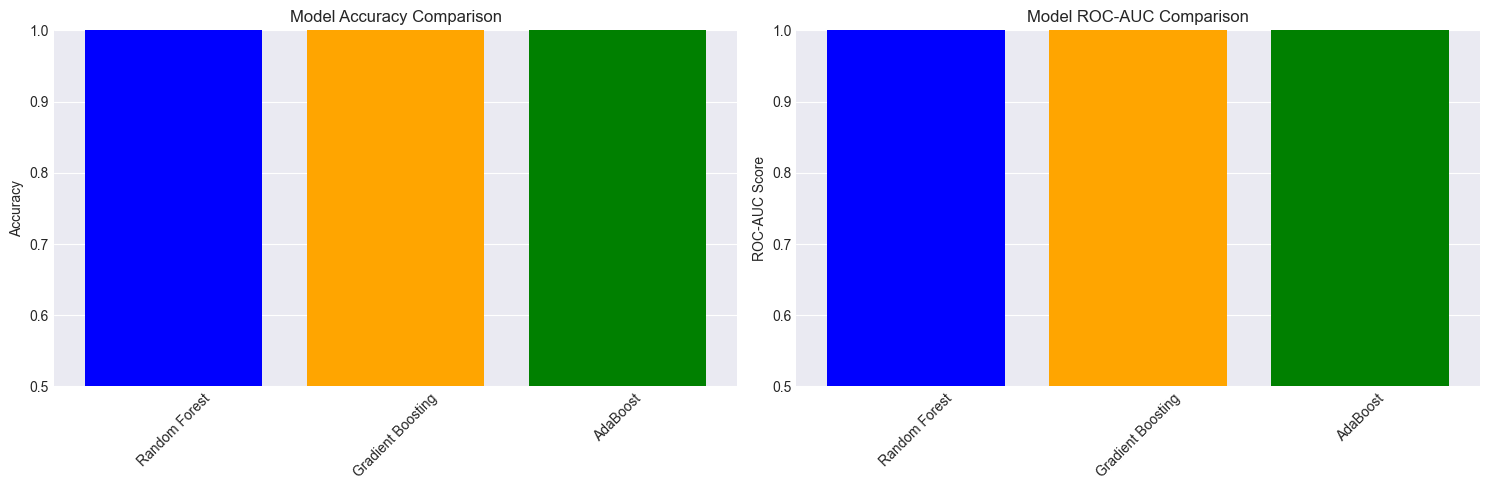


🏆 Best Model: Random Forest


In [70]:
# Compare all models
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'AdaBoost'],
    'Accuracy': [accuracy_rf, accuracy_gb, accuracy_ada],
    'ROC-AUC': [roc_auc_rf, roc_auc_gb, roc_auc_ada]
})

model_comparison = model_comparison.sort_values('ROC-AUC', ascending=False)
print("Model Comparison:")
print("=" * 50)
print(model_comparison.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(model_comparison['Model'], model_comparison['Accuracy'], color=['blue', 'orange', 'green'])
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0.5, 1.0])
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(model_comparison['Model'], model_comparison['ROC-AUC'], color=['blue', 'orange', 'green'])
axes[1].set_title('Model ROC-AUC Comparison')
axes[1].set_ylabel('ROC-AUC Score')
axes[1].set_ylim([0.5, 1.0])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

best_model_name = model_comparison.iloc[0]['Model']
print(f"\n🏆 Best Model: {best_model_name}")

## 16. ROC Curve Comparison

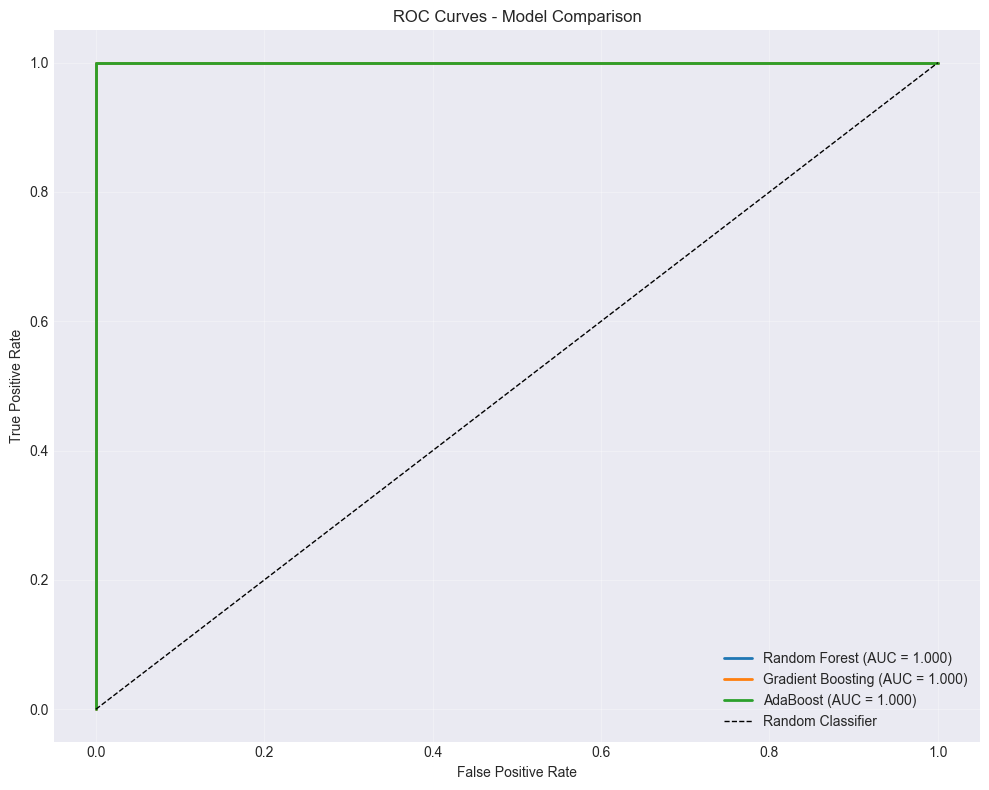

In [71]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})', linewidth=2)

# Gradient Boosting ROC
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.3f})', linewidth=2)

# AdaBoost ROC
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_pred_proba_ada)
plt.plot(fpr_ada, tpr_ada, label=f'AdaBoost (AUC = {roc_auc_ada:.3f})', linewidth=2)

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 17. Save Best Model

In [72]:
# Determine best model
models = {
    'Random Forest': (rf_model, roc_auc_rf, accuracy_rf),
    'Gradient Boosting': (gb_model, roc_auc_gb, accuracy_gb),
    'AdaBoost': (ada_model, roc_auc_ada, accuracy_ada)
}

best_model_name = max(models.items(), key=lambda x: x[1][1])[0]
best_model, best_roc_auc, best_accuracy = models[best_model_name]

# Generate timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save model
model_filename = f'models/best_model_{best_model_name.lower().replace(" ", "_")}_{timestamp}.joblib'
joblib.dump(best_model, model_filename)
print(f"✓ Model saved: {model_filename}")

# Save label encoders
encoders_filename = f'models/label_encoders_{timestamp}.joblib'
joblib.dump(label_encoders, encoders_filename)
print(f"✓ Label encoders saved: {encoders_filename}")

# Save target encoder
target_encoder_filename = f'models/target_encoder_{timestamp}.joblib'
joblib.dump(target_encoder, target_encoder_filename)
print(f"✓ Target encoder saved: {target_encoder_filename}")

# Save scaler
scaler_filename = f'models/scaler_{timestamp}.joblib'
joblib.dump(scaler, scaler_filename)
print(f"✓ Scaler saved: {scaler_filename}")

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'timestamp': timestamp,
    'accuracy': float(best_accuracy),
    'roc_auc': float(best_roc_auc),
    'features': X.columns.tolist(),
    'target_classes': target_encoder.classes_.tolist(),
    'model_file': model_filename,
    'encoders_file': encoders_filename,
    'target_encoder_file': target_encoder_filename,
    'scaler_file': scaler_filename
}

metadata_filename = f'models/model_metadata_{timestamp}.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"✓ Metadata saved: {metadata_filename}")

print(f"\n{'='*50}")
print(f"🎉 Best Model Summary:")
print(f"{'='*50}")
print(f"Model: {best_model_name}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"ROC-AUC: {best_roc_auc:.4f}")
print(f"Saved at: {timestamp}")

✓ Model saved: models/best_model_random_forest_20251215_121916.joblib
✓ Label encoders saved: models/label_encoders_20251215_121916.joblib
✓ Target encoder saved: models/target_encoder_20251215_121916.joblib
✓ Scaler saved: models/scaler_20251215_121916.joblib
✓ Metadata saved: models/model_metadata_20251215_121916.json

🎉 Best Model Summary:
Model: Random Forest
Accuracy: 1.0000
ROC-AUC: 1.0000
Saved at: 20251215_121916


## 18. Model Prediction Example

In [73]:
# Example prediction with the best model
print("Example Prediction:")
print("=" * 50)

# Take a few samples from test set
sample_indices = [0, 1, 2, 3, 4]
X_sample = X_test_scaled[sample_indices]
y_sample_true = y_test[sample_indices]

# Make predictions
y_sample_pred = best_model.predict(X_sample)
y_sample_proba = best_model.predict_proba(X_sample)

# Display results
for i, (true_label, pred_label, proba) in enumerate(zip(y_sample_true, y_sample_pred, y_sample_proba)):
    true_class = target_encoder.inverse_transform([true_label])[0]
    pred_class = target_encoder.inverse_transform([pred_label])[0]
    confidence = max(proba) * 100
    
    print(f"\nSample {i+1}:")
    print(f"  True: {true_class}")
    print(f"  Predicted: {pred_class}")
    print(f"  Confidence: {confidence:.2f}%")
    print(f"  Probabilities: Lancar={proba[0]*100:.2f}%, Tidak Lancar={proba[1]*100:.2f}%")

Example Prediction:

Sample 1:
  True: Lancar
  Predicted: Lancar
  Confidence: 99.78%
  Probabilities: Lancar=99.78%, Tidak Lancar=0.22%

Sample 2:
  True: Lancar
  Predicted: Lancar
  Confidence: 98.91%
  Probabilities: Lancar=98.91%, Tidak Lancar=1.09%

Sample 3:
  True: Tidak Lancar
  Predicted: Tidak Lancar
  Confidence: 99.76%
  Probabilities: Lancar=0.24%, Tidak Lancar=99.76%

Sample 4:
  True: Tidak Lancar
  Predicted: Tidak Lancar
  Confidence: 99.96%
  Probabilities: Lancar=0.04%, Tidak Lancar=99.96%

Sample 5:
  True: Tidak Lancar
  Predicted: Tidak Lancar
  Confidence: 100.00%
  Probabilities: Lancar=0.00%, Tidak Lancar=100.00%


## 19. Summary Report

In [74]:
print("\n" + "="*70)
print(" " * 20 + "FINAL ANALYSIS SUMMARY")
print("="*70)

print(f"\n📊 DATASET INFORMATION:")
print(f"  - Total Records: {len(df)}")
print(f"  - Total Features: {len(X.columns)}")
print(f"  - Target Variable: Kolektabilitas (Lancar / Tidak Lancar)")

print(f"\n🎯 TARGET DISTRIBUTION:")
target_dist = df['Kolektabilitas'].value_counts()
for label, count in target_dist.items():
    pct = count / len(df) * 100
    print(f"  - {label}: {count} ({pct:.2f}%)")

print(f"\n📈 FEATURES USED:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col}")

print(f"\n🤖 MODELS TRAINED:")
for model_name, (_, roc_auc, accuracy) in models.items():
    print(f"  - {model_name}:")
    print(f"      Accuracy: {accuracy:.4f}")
    print(f"      ROC-AUC: {roc_auc:.4f}")

print(f"\n🏆 BEST MODEL:")
print(f"  - Model: {best_model_name}")
print(f"  - Accuracy: {best_accuracy:.4f}")
print(f"  - ROC-AUC: {best_roc_auc:.4f}")

print(f"\n💾 SAVED FILES:")
print(f"  - Model: {model_filename}")
print(f"  - Label Encoders: {encoders_filename}")
print(f"  - Target Encoder: {target_encoder_filename}")
print(f"  - Scaler: {scaler_filename}")
print(f"  - Metadata: {metadata_filename}")

print(f"\n" + "="*70)
print(" " * 25 + "✅ ANALYSIS COMPLETE")
print("="*70)


                    FINAL ANALYSIS SUMMARY

📊 DATASET INFORMATION:
  - Total Records: 1500
  - Total Features: 12
  - Target Variable: Kolektabilitas (Lancar / Tidak Lancar)

🎯 TARGET DISTRIBUTION:
  - Lancar: 1100 (73.33%)
  - Tidak Lancar: 400 (26.67%)

📈 FEATURES USED:
  1. Pekerjaan
  2. Usia
  3. Status Pernikahan
  4. Produk
  5. Sub Produk
  6. Plafond
  7. Jangka Waktu
  8. Hasil Prescreening SLIK
  9. Hasil Prescreening SIPKUR
  10. Hasil Prescreening Dukcapil
  11. Hasil Prescreening
  12. Status

🤖 MODELS TRAINED:
  - Random Forest:
      Accuracy: 1.0000
      ROC-AUC: 1.0000
  - Gradient Boosting:
      Accuracy: 1.0000
      ROC-AUC: 1.0000
  - AdaBoost:
      Accuracy: 1.0000
      ROC-AUC: 1.0000

🏆 BEST MODEL:
  - Model: Random Forest
  - Accuracy: 1.0000
  - ROC-AUC: 1.0000

💾 SAVED FILES:
  - Model: models/best_model_random_forest_20251215_121916.joblib
  - Label Encoders: models/label_encoders_20251215_121916.joblib
  - Target Encoder: models/target_encoder_2025121